# Freyberg Model Schur Complement Example
This example uses a synthetic model (described below) to illustrate the `pyemu` capabilities of the Schur complement for calculating posterior covariance.

Note that, in addition to `pyemu`, this notebook relies on `flopy`. `flopy` can be obtained (along with installation instructions) at https://github.com/modflowpy/flopy.

In [1]:
%matplotlib inline
from __future__ import print_function
import os
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle as rect
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", message="ModflowDis.sr is deprecated. use Modflow.sr")
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl


## Model background
This example is based on the synthetic classroom model of Freyberg(1988).  The  model is a 2-dimensional MODFLOW model with 1 layer,  40 rows, and 20 columns.  The model has 2 stress periods: an initial steady-state stress period used for calibration, and a 5-year transient stress period.  The calibration period uses the recharge and well flux of Freyberg(1988); the last stress period use 25% less recharge and 25% more pumping to represent future conditions for a forecast period.

The inverse problem has 761 parameters: hydraulic conductivity of each active model cell, calibration and forecast period recharge multipliers, storage and specific yield, calibration and forecast well flux for each of the six wells, and river bed conductance for each 40 cells with river-type boundary conditions.  The inverse problem has 12 head obseravtions, measured at the end of the steady-state calibration period.  The forecasts of interest include the sw-gw exchange flux during both stress periods (observations named ```sw_gw_0``` and ``sw_gw_1``), and the water level in well cell 6 located in at row 28 column 5 at the end of the stress periods (observations named ```or28c05_0``` and ```or28c05_1```).  The forecasts are included in the Jacobian matrix as zero-weight observations. The model files, pest control file and previously-calculated jacobian matrix are in the `freyberg/` folder


Freyberg, David L. "AN EXERCISE IN GROUND‐WATER MODEL CALIBRATION AND PREDICTION." Groundwater 26.3 (1988): 350-360.

/Users/jwhite/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


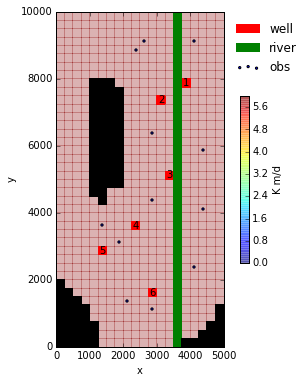

In [2]:
import flopy

# load the model
model_ws = os.path.join("Freyberg","extra_crispy")
ml = flopy.modflow.Modflow.load("freyberg.nam",model_ws=model_ws)

# plot some model attributes
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111,aspect="equal")
ml.upw.hk.plot(axes=[ax],colorbar="K m/d",alpha=0.3)
ml.wel.stress_period_data.plot(axes=[ax])
ml.riv.stress_period_data.plot(axes=[ax])

# plot obs locations
obs = pd.read_csv(os.path.join("freyberg","misc","obs_rowcol.dat"),delim_whitespace=True)
obs_x = [ml.sr.xcentergrid[r-1,c-1] for r,c in obs.loc[:,["row","col"]].values]
obs_y = [ml.sr.ycentergrid[r-1,c-1] for r,c in obs.loc[:,["row","col"]].values]
ax.scatter(obs_x,obs_y,marker='.',label="obs")

#plot names on the pumping well locations
wel_data = ml.wel.stress_period_data[0]
wel_x = ml.sr.xcentergrid[wel_data["i"],wel_data["j"]]
wel_y = ml.sr.ycentergrid[wel_data["i"],wel_data["j"]]
for i,(x,y) in enumerate(zip(wel_x,wel_y)):
    ax.text(x,y,"{0}".format(i+1),ha="center",va="center")

ax.set_ylabel("y")
ax.set_xlabel("x")

ax.add_patch(rect((0,0),0,0,label="well",ec="none",fc="r"))
ax.add_patch(rect((0,0),0,0,label="river",ec="none",fc="g"))

ax.legend(bbox_to_anchor=(1.5,1.0),frameon=False)
plt.savefig("domain.pdf")

The plot shows the Freyberg (1988) model domain.  The colorflood is the hydraulic conductivity $\left(\frac{m}{d}\right)$.  Red and green cells correspond to well-type and river-type boundary conditions. Blue dots show the locations of water levels used for calibration.

## Using `pyemu`

In [3]:
import pyemu

First we need to create a linear_analysis object of the `schur`  derived type, which replicates the behavior of the `PREDUNC` suite of PEST for calculating posterior parameter covariance.  We pass it the name of the Jacobian matrix file.  Since we don't pass an explicit argument for `parcov` or `obscov`, `pyemu` attempts to build them from the parameter bounds and observation weights in a pest control file (.pst) with the same base case name as the Jacobian.  This assumes that the bounds represent the mean value + and - 2 times the standard deviation.

Since we are interested in forecast uncertainty as well as parameter uncertainty, we also pass the names of the forecast sensitivity vectors we are interested in, which are stored in the Jacobian as well.  Note that the `forecasts` argument can be a mixed list of observation names, other Jacobian files or PEST-compatible ASCII matrix files.

In [4]:
# get the list of forecast names from the pest++ argument in the pest control file
jco = os.path.join("freyberg","freyberg_drop.jcb") # just set the path and filename for the jco file
pst = pyemu.Pst(jco.replace(".jcb",".pst"))     # use the jco name with extention "pst" for the control file
la = pyemu.Schur(jco=jco, pst=pst, forecasts=pst.pestpp_options["forecasts"].split(','),verbose=False)
print("observations,parameters in Jacobian:",la.jco.shape)


observations,parameters in Jacobian: (704, 761)


##  General parameter uncertainty analysis--evaluating posterior parameter covariance
Let's calculate and save the posterior parameter covariance matrix. In this linear analysis, the posterior covariance represents the updated covariance following notional calibration as represented by the Jacobian matrix and both prior parameter and epistemic observation covariance matrices using the Schur complement:

In [5]:
la.posterior_parameter.to_ascii(jco+"_post.cov") #writes posterior covariance to a text file

You can open this file (it will be called `freyberg.jcb_post.cov`) in a text editor to examine.  The diagonal of this matrix is the posterior variance of each parameter. Since we already calculated the posterior parameter covariance matrix, additional calls to the `posterior_parameter` decorated methods only require access--they do not recalculate the matrix:


In [6]:
la.posterior_parameter.to_dataframe().sort_index().sort_index(axis=1).iloc[0:3,0:3] #easy to read in the notebook

,hkr00c00,hkr00c01,hkr00c02
hkr00c00,2.499965e-01,-7.209789e-07,-0.000004
hkr00c01,-7.209789e-07,2.499990e-01,-0.000002
hkr00c02,-4.250266e-06,-1.825146e-06,0.249992


We can see the posterior variance of each parameter along the diagonal of this matrix. Now, let's make a simple plot of prior vs posterior uncertainty for the 761 parameters. The ``.get_parameters_summary()`` method is the easy way:

,percent_reduction,post_var,prior_var
rch_1,43.410074,0.000269,0.000475
hkr30c15,31.245274,0.171887,0.250000
hkr03c11,26.392140,0.184020,0.250000
hkr34c09,25.032159,0.187420,0.250000
hkr04c10,23.885174,0.190287,0.250000
hkr22c12,22.004299,0.194989,0.250000
hkr25c06,20.875178,0.197812,0.250000
hkr35c12,19.770523,0.200574,0.250000
hkr35c10,18.600160,0.203500,0.250000
hkr04c16,17.182900,0.207043,0.250000


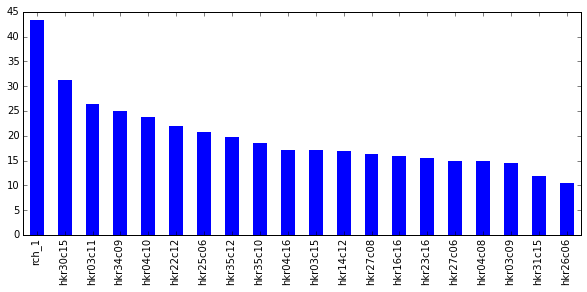

In [7]:
#get the parameter uncertainty dataframe and sort it
par_sum = la.get_parameter_summary().sort_values("percent_reduction",ascending=False)
#make a bar plot of the percent reduction ((prior - posterior) / prior) for the first 20 parameters 
par_sum.loc[par_sum.index[:20],"percent_reduction"].plot(kind="bar",figsize=(10,4),edgecolor="none")
#echo the first 10 entries
par_sum.iloc[0:10,:]

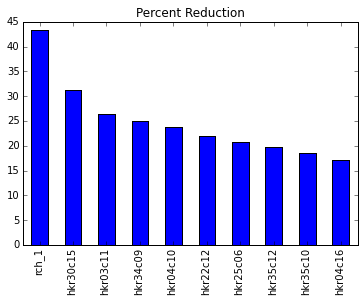

In [8]:
# we can plot up the top 10 uncertainty reductions
par_sum.iloc[0:10,:]['percent_reduction'].plot(kind='bar')
plt.title('Percent Reduction')

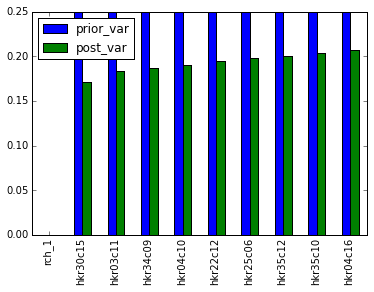

In [9]:
# we can plot up the prior and posterior variance of the top 10 percent reductions
par_sum.iloc[0:10,:][['prior_var','post_var']].plot(kind='bar')

We can see that calibrating the model to the 12 water levels reduces the uncertainty of the calibration period recharge parameter (`rch_0`) by 50%.  Additionally, the hydraulic conductivity of many model cells is also reduced.  

Now lets look at the other end of the parameter uncertainty summary -- the values with the _least_ amount of uncertainty reduction.  Note that calling ``get_parameter_summary()`` again results in no additional computation but is just accessing information already calculated

,percent_reduction,post_var,prior_var
wf5_2,-2.220446e-14,0.000475,0.000475
hkr39c14,0.000000e+00,0.250000,0.250000
wf6_2,0.000000e+00,0.000475,0.000475
wf4_2,0.000000e+00,0.000475,0.000475
hkr01c19,0.000000e+00,0.250000,0.250000
hkr00c19,0.000000e+00,0.250000,0.250000
ss,0.000000e+00,0.250000,0.250000
rcond39,0.000000e+00,0.250000,0.250000
rch_2,0.000000e+00,0.000475,0.000475
rcond19,0.000000e+00,0.250000,0.250000


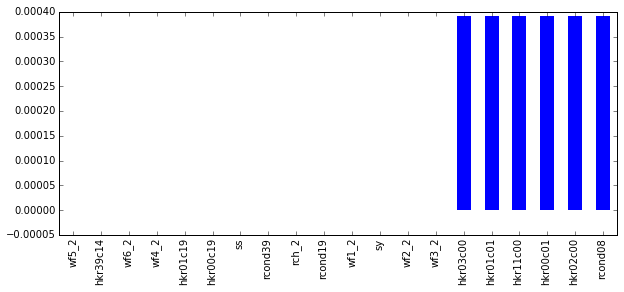

In [10]:
# sort in increasing order
par_sum = la.get_parameter_summary().sort_values("percent_reduction") #without 'ascending=False'
# plot the first 20
par_sum.loc[par_sum.index[:20],"percent_reduction"].plot(kind="bar",figsize=(10,4),edgecolor="none")
#echo the first 10 
par_sum.iloc[0:20,:]

We see that several parameters are unaffected by calibration - these are mostly parameters that represent forecast period uncertainty (parameters that end with ```_2```), but there are also some hydraulic conductivities that are uninformed by the 12 water level observations.

The naming conventions for the hydraulic conductivity parameters include their row and column location (starting at 0 rather than 1) so, for example, `hkr39r14` indicates hydraulic conductivity in row 39, column 14. This location is in a constant head cell, so it makes sense it would be uninformed by head values anywhere in the model. The other hydraulic conductivity values are in the upper right hand corner of the model, far from the observations in a stagnant area with limited groundwater flow.

We can also make a map of uncertainty reduction for the hydraulic conductivity parameters using some ```flopy``` action

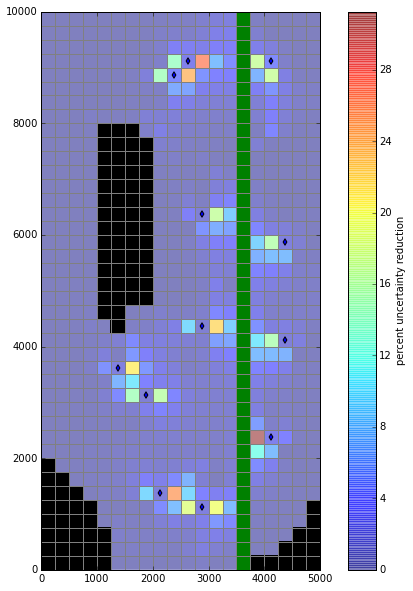

In [11]:
hk_pars = par_sum.loc[par_sum.groupby(lambda x:"hk" in x).groups[True],:]
hk_pars.loc[:,"names"] = hk_pars.index
names = hk_pars.names
# use the parameter names to parse out row and column locations
hk_pars.loc[:,"i"] = names.apply(lambda x: int(x[3:5]))
hk_pars.loc[:,"j"] = names.apply(lambda x: int(x[6:8]))
# set up an array of the value -1 the same shape as the HK array in the UPW package
unc_array = np.zeros_like(ml.upw.hk[0].array) - 1
# fill the array with percent reduction values
for i,j,unc in zip(hk_pars.i,hk_pars.j,hk_pars.percent_reduction):
    unc_array[i,j] = unc 
# setting the array values that are still -1 (e.g. no percent reduction value in the cell)
# to np.NaN so that they don't get displayed on the plot
unc_array[unc_array == -1] = np.NaN

# plot some model attributes
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111,aspect="equal")
cb = ax.imshow(unc_array,interpolation="none",alpha=0.5,extent=ml.dis.sr.get_extent())
plt.colorbar(cb,label="percent uncertainty reduction")
#ml.wel.stress_period_data.plot(axes=[ax])
ml.riv.stress_period_data.plot(axes=[ax])
# plot obs locations
obs = pd.read_csv(os.path.join("freyberg","misc","obs_rowcol.dat"),delim_whitespace=True)
obs_x = [ml.sr.xcentergrid[r-1,c-1] for r,c in obs.loc[:,["row","col"]].values]
obs_y = [ml.sr.ycentergrid[r-1,c-1] for r,c in obs.loc[:,["row","col"]].values]
ax.scatter(obs_x,obs_y,marker='d')
modelmap = flopy.plot.ModelMap(model=ml)
modelmap.plot_grid()




As expected, most of the information in the observations is reduces uncertainty for the hydraulic conductivity parameters near observations themselves. Areas farther from the observations experience less reduction in uncertainty due to calibration. 

## Forecast uncertainty
Now let's examine the prior and posterior variance of the forecasts. The uncertainty in parameters directly impacts the uncertainty of forecasts made with the model. Four forecasts were identified for analysis, as described above:

1. `sw_gw_0`: the surface water/groundwater exchange during the calibration stress period
2. `sw_gw_1`: the surface water/groundwater exchange during the prediction stress period
3. `or28c05_0`: the head in well cell 6 (row 28, column 5) at the end of the calibration stress period
4. `or28c05_1`: the head in well cell 6 (row 28, column 5) at the end of the prediction stress period


,percent_reduction,post_var,prior_var
sw_gw_1,0.516452,110972.261543,111548.355615
sw_gw_0,36.662109,50438.518215,79634.034592
or28c05_1,13.806425,0.666633,0.773414
or28c05_0,73.547647,0.106080,0.401023


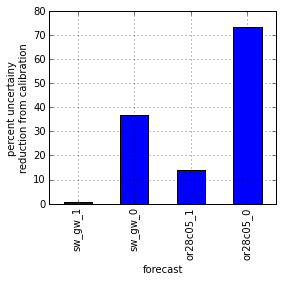

In [12]:
# get the forecast summary then make a bar chart of the percent_reduction column
fig = plt.figure(figsize=(4,4))
ax = plt.subplot(111)
ax = la.get_forecast_summary().percent_reduction.plot(kind='bar',ax=ax,grid=True)
ax.set_ylabel("percent uncertainy\nreduction from calibration")
ax.set_xlabel("forecast")
plt.tight_layout()
plt.savefig("forecast_sum.pdf")
la.get_forecast_summary()

Notice the spread on the uncertainty reduction: some forecasts benefit more from calibration than others.  For example, ```or28c05_0```, the calibration-period water level forecast, benefits from calibration since its uncertainty is reduced by 75%, while ```sw_gw_1```, the forecast-period surface-water groundwater exchange forecast does not benefit from calibration - its uncertainty is unchanged by calibration

## Parameter contribution to forecast uncertainty

### Overview
As we observed above, information cascades from observations to parameters and then out to forecasts. With specific forecasts of interest, we can evaluate which information contributes most to forecast uncertainty. This is accomplished by assuming a parameter (or group of parameters) is perfectly known and assessing the forecast uncertainty under that assumption. Of course, this is a pretty serious approximation because perfect knowledge of a parameter can never be obtained in reality. In fact, it is difficult to calculate what, for example, a pumping test will provide in terms of uncertainty reduction for a parameter. Nonetheless, this metric can still provide important insights into model dynamics and help guide future data collection efforts.



## Parameter contribution to forecast uncertainty

### Overview
As we observed above, information cascades from observations to parameters and then out to forecasts. With specific forecasts of interest, we can evaluate which information contributes most to forecast uncertainty. This is accomplished by assuming a parameter (or group of parameters) is perfectly known and assessing the forecast uncertainty under that assumption. Of course, this is a pretty serious approximation because perfect knowledge of a parameter can never be obtained in reality. In fact, it is difficult to calculate what, for example, a pumping test will provide in terms of uncertainty reduction for a parameter. Nonetheless, this metric can still provide important insights into model dynamics and help guide future data collection efforts.

### Evaluating parameters by groups
With the Freyberg example, we can evaluate parameter contributions to forecast uncertainty with groups of parameters by type. 

In [13]:
df = la.get_par_group_contribution()
df

or28c05_0                          or28c05_1                      \
        percent_reduce      post     prior percent_reduce      post     prior   
base         73.547647  0.106080  0.401023      13.806425  0.666633  0.773414   
hk           99.745281  0.000248  0.097405       0.910641  0.578797  0.584116   
rcond        73.547742  0.106076  0.401010      13.806877  0.666630  0.773414   
storage      73.547647  0.106080  0.401023      48.939334  0.111409  0.218190   
welflux      73.545233  0.105826  0.400026      13.843987  0.664709  0.771518   
rch          65.580640  0.104851  0.304629      14.548550  0.637824  0.746417   

               sw_gw_0                                    sw_gw_1  \
        percent_reduce          post         prior percent_reduce   
base         36.662109  50438.518215  79634.034592       0.516452   
hk           98.739102    974.630935  77296.576233       0.754583   
rcond        36.687582  50412.403085  79624.827130       0.516439   
storage      36.662109  50438.518215  79634.034592       2.951521   
welflux      37.006038  48841.481656  77533.592215       0.532564   
rch          12.273264   3901.302851   4447.108198       0.316934   

                                       
                  post          prior  
base     110972.261543  111548.355615  
hk       109623.739808  110457.231456  
rcond    110967.446517  111543.500268  
storage   18942.456123   19518.550195  
welflux  107876.154982  108453.740158  
rch       95915.445036   96220.400383

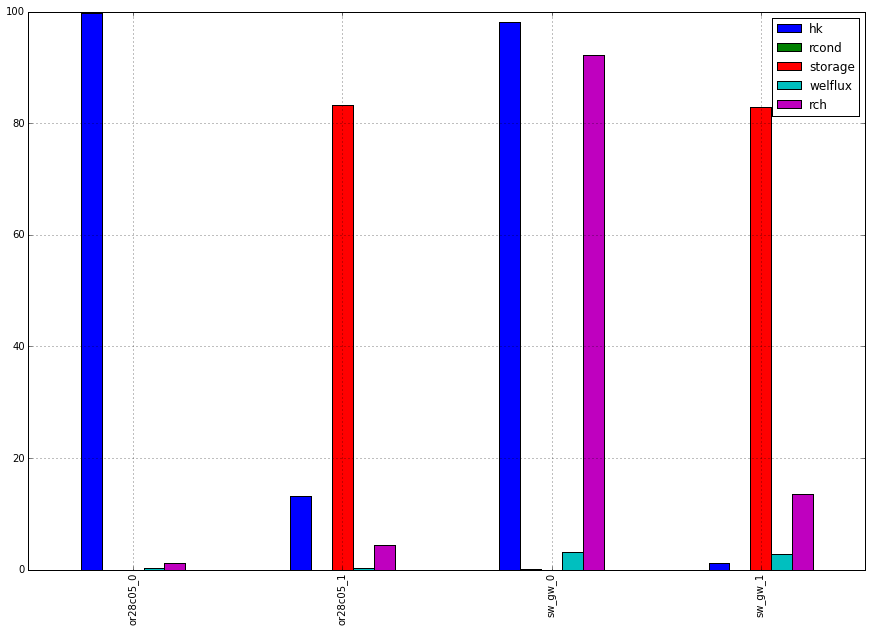

In [14]:
#select out the posterior column
df_reduce = df.xs("post",axis=1,level=1)
#calc the percent reduction in posterior
df_percent = 100.0 * (df_reduce.loc["base",:]-df_reduce)/df_reduce.loc["base",:]
#drop the base column
df_percent = df_percent.iloc[1:,:]
#transpose and plot
ax = df_percent.T.plot(kind="bar", ylim=[0,100],figsize=(15,10))
ax.grid()


We see some interesting results here.  The sw-gw flux during calibration (```sw_gw_0```) is influenced by both recharge and hk uncertainty, but the forecast period sw-gw flux is influenced most by recharge uncertainty. For the water level forecasts (```or28c05_0 and or28c05_1```), the results are similar: the forecast of water level at the end of the calibration period benefits most from hk knowledge, while the forecast period water level is most informed by recharge and storage. 

As expected, in both cases `rcond` has no impact on forecast uncertainty (typically, river conductance is insensitive and noninfluential across a wide range of values) and `storage` plays no role in the steady-state calibration period but is important for the transient forecast period. Uncertainty in `welflux` plays a small role but is eclipsed by `rch` which is responsible for a much more substantial amount of flux.

### Evaluating an alternative grouping 
Let's repeat the analysis, but now group the parameters differently:

The forcings in the model are the well pumping rates (`welflux`) and recharge (`rch`). The suffix `_1` indicates the calibration period while `_2` indicates the forecast period. Based on this, we can create two groupings for the forcings in the two periods. Other parameters (hydraulic conductivity, storage, and river conductance) are relegated to a third group of properties.

If we create a dictionary identifying groups as keys with lists of parameter names as values, we can pass that to the `get_par_contribution()` method. The dataframe returned will group results by the keys of the dictionary.

In [15]:
pnames = la.pst.par_names
fore_names = [pname for pname in pnames if pname.endswith("_2")]
props = [pname for pname in pnames if pname[:2] in ["hk","ss","sy","rc"] and "rch" not in pname]
cal_names = [pname for pname in pnames if pname.endswith("_1")]
pdict = {'forecast forcing':fore_names,"properties":props,"calibration forcing":cal_names}
df = la.get_par_contribution(pdict)

In [16]:
#select out the posterior column
df_reduce = df.xs("post",axis=1,level=1)
#calc the percent reduction in posterior
df_percent = 100.0 * (df_reduce.loc["base",:]-df_reduce)/df_reduce.loc["base",:]
#drop the base column
df_percent = df_percent.iloc[1:,:]
df_percent

,or28c05_0,or28c05_1,sw_gw_0,sw_gw_1
calibration forcing,1.414155e+00,1.078801,9.660491e+01,0.512794
properties,9.977243e+01,96.463971,9.865286e+01,84.150120
forecast forcing,6.541186e-14,3.535723,-4.327620e-14,15.849490


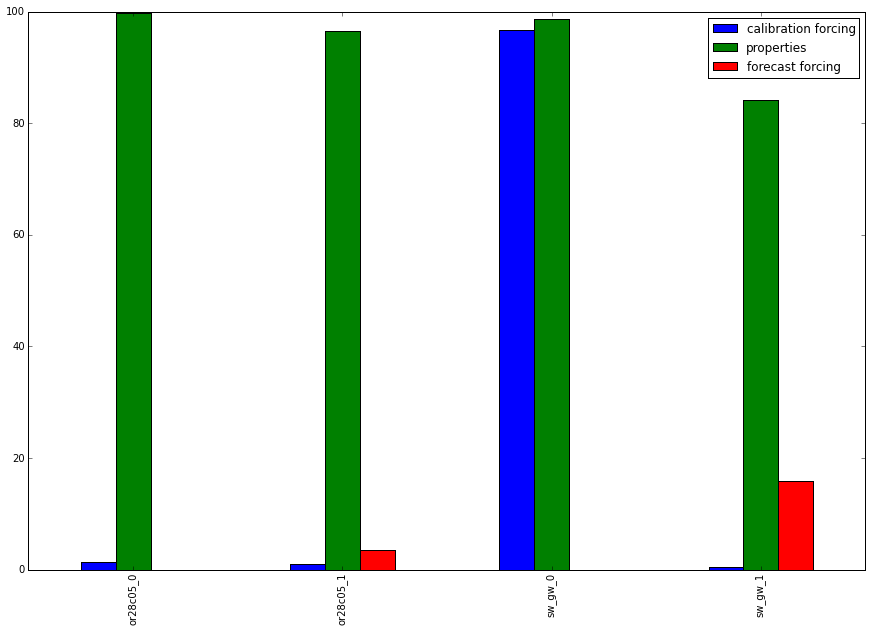

In [17]:
#transpose and plot
df_percent.T.plot(kind="bar", ylim=[0, 100], figsize=(15,10))

These results are also intuitive. For both forecasts originating from the second model stress period (the "forecast" period), the forecast-peroid forcings (which represent future recharge and future water use) play a role in reducing forecast uncertainty for the forecast period. Calibration forcings (current recharge and water use) are important for the calibration-period `sw_gw` exchange forecast (``sw_gw_0``), but are dwarfed by properties for the calibration-period head forecast (``or28c05_0``). Properties are important across the board, but in both cases their importance is reduced in the forecast period due to the increasing importance of forcing.

Evaluation of these dynamics is useful to understand the dynamics of the model, but it is difficult to quantify just how uncertainty can be reduced directly on parameters. On the other hand, we know that observations provide information on parameters through the calibration process. In a sense it is more straightforward to quantify how observation information impacts forecast uncertainty, so we can explore the worth of observation data.

# Data worth analysis

## Overview
Data worth can be broken into two main categories: the worth of data pertaining directly to parameters, and the data pertaining to observations.

There are two main applications of data worth analysis. One is to evaluate the worth of observations in an existing network of observations, and the other is to evaluate the value of potential new observations. 

## Data worth--evaluating the value of existing observations
Now, let's try to identify which observations are most important to reducing the posterior uncertainty (e.g.the forecast worth of every observation).  We simply recalculate Schur's complement without some observations and see how the posterior forecast uncertainty increases

```get_removed_obs_group_importance()``` is a thin wrapper that calls the underlying ```get_removed_obs_importance()``` method using the observation groups in the pest control file and stacks the results into a ```pandas DataFrame```.  This method tests how important non-zero weight observations are for reducing forecast uncertainty. The metric provided is the forecast uncertainty that can be attributed to each observation group. 

This call will test all of the non-forecast, non-zero weight observations in the PEST data set to see which ones are most important. 


In [18]:
df_worth = la.get_removed_obs_importance()
df_worth

,or28c05_0,or28c05_1,sw_gw_0,sw_gw_1
base,0.106080,0.666633,50438.518215,110972.261543
or16c17_0,0.106106,0.666790,51388.723150,110991.764956
or03c16_0,0.106119,0.666843,52004.769128,110994.442952
or23c17_0,0.106095,0.666782,51222.032642,110989.533067
or27c07_0,0.155371,0.695619,50799.036202,110982.086156
or03c10_0,0.106082,0.666633,50447.675953,110975.502144
or22c11_0,0.106086,0.666919,50609.657619,110986.121875
or14c11_0,0.106105,0.667003,51700.071165,111013.045280
or30c16_0,0.106100,0.666691,50724.236720,110980.769498
or35c11_0,0.106108,0.667686,50659.386679,110999.965290


The ```base``` row contains the results of the Schur's complement calculation using all observations.  The increase in posterior forecast uncertainty for each of the 12 water level observations (e.g. or17c17 is the observation in row 18 column 18) show how much forecast uncertainty increases when that particular observation is not used in history matching.  So we see again that each forecast depends on the observations differently.

We can normalize the importance to the maximum importance value to create a metric of data worth which will be between 0 and 100%. Then we can also determine which observation has the highest data worth with respect to each forecast and also report how much reduction in uncertainty it is responsible for (e.g. how much does forecast uncertainty increase if that data point is not used for history matching)



In [19]:
# a little processing of df_worth
df_base = df_worth.loc["base",:].copy()
df_imax = df_worth.apply(lambda x:x-df_base,axis=1).idxmax()
df_max = 100.0 * (df_worth.apply(lambda x:x-df_base,axis=1).max() / df_base)
df_par = pd.DataFrame([df_imax,df_max],index=["most important observation","percent increase when left out"])
df_par

,or28c05_0,or28c05_1,sw_gw_0,sw_gw_1
most important observation,or27c07_0,or27c07_0,or03c16_0,or34c08_0
percent increase when left out,46.4656,4.34813,3.10527,0.0858822


We see that observation ```or27c07_0``` is the most important for the water level forecasts (```or28c05_0``` and ```or28c05_1```), while observation ```or10c02_0``` is the most important for the surface water groundwater exchange forecasts (```sw_gw_0``` and ```sw_gw_1```). Also, observation ```or10c02_0```) results in a much greater increase in uncertainty for forecast ```sw_gw_0``` than it does for ```sw_gw_1```.

## Data worth--evaluating the potential value of new observations
A potential water-level observation for each active model cell was also "carried" in the PEST control file.  This means we can run this same analysis to find the best next place to collect a new water level.  This takes a little longer because it is rerunning the schur's complement calculations many times, so this section can be skipped.

### Define the potential observation locations
First we need a list of the observations with zero weight and that start with `"or"`--- (these are the synthetic proposed locations)

In [20]:
#new_obs_list = [i[1].obsnme for i in pst.observation_data.iterrows() 
#                if i[1].weight==0 and i[1].obsnme[0:2] =='or' ]
pst.observation_data.index = pst.observation_data.obsnme

new_obs_list = pst.observation_data.groupby(lambda x: x[0:2] == "or" and 
                                            pst.observation_data.loc[x,"weight"] == 0).groups[True] 
# need to explicitly drop out the two predictions --- temporary kludge
[new_obs_list.remove(i) for i in ['or28c05_0','or28c05_1']]
print (len(new_obs_list))

692


This takes a while...

In [21]:
df_worth_new= la.get_added_obs_importance(base_obslist=pst.nnz_obs_names,
                                          obslist_dict=new_obs_list,reset_zero_weight=True)

In [22]:
df_worth_new

,or28c05_0,or28c05_1,sw_gw_0,sw_gw_1
base,0.106080,0.666633,50438.518215,110972.261543
or13c14_0,0.106080,0.666633,50438.457824,110972.261001
or22c00_0,0.105253,0.666621,49603.243088,110955.082876
or25c17_0,0.106080,0.666633,50437.270618,110972.217431
or02c06_0,0.106027,0.666623,50107.548720,110959.984155
or23c19_0,0.106080,0.666632,50433.354445,110972.164270
or18c02_0,0.105327,0.666626,49014.849262,110942.079733
or14c09_0,0.106079,0.666623,50394.721893,110971.394729
or25c19_0,0.106080,0.666632,50431.562398,110972.136756
or06c14_0,0.106080,0.666633,50438.403584,110972.260527


Similar to the value of existing data, these results are specific to the forecast of interest. However, when adding potential new observation data, we are looking at how uncertainty will _decrease_ if a proposed observation is _added_  to the 12 water level observations already being used for calibration(this is opposite of looking for the _increase_ in forecast uncertainty if an existing observation is _removed_). 

For each forecast, we can first determine which proposed new observation is most valuable.

In [23]:
# a little processing of df_worth
df_new_base = df_worth_new.loc["base",:].copy()
df_new_imax = df_worth_new.apply(lambda x:df_base-x,axis=1).idxmax()
df_new_worth = 100.0 * (df_worth_new.apply(lambda x:df_base-x,axis=1) / df_new_base)
df_new_max = df_new_worth.max()
df_par_new = pd.DataFrame([df_new_imax,df_new_max],index=["most important observation","percent decrease when added"])
df_par_new

,or28c05_0,or28c05_1,sw_gw_0,sw_gw_1
most important observation,or29c05_0,or29c05_0,or13c01_0,or13c01_0
percent decrease when added,6.40216,0.612756,3.88124,0.036201


### Some processing for plotting...


In [24]:
df_new_worth_plot = df_new_worth[df_new_worth.index != 'base'].copy()
df_new_worth_plot.loc[:,'names'] = df_new_worth_plot.index
names = df_new_worth_plot.names
df_new_worth_plot.loc[:,"i"] = names.apply(lambda x: int(x[2:4]))
df_new_worth_plot.loc[:,"j"] = names.apply(lambda x: int(x[5:7]))
df_new_worth_plot.loc[:,'SP'] = names.apply(lambda x: int(x[-1]))
df_new_worth_plot.head()

,or28c05_0,or28c05_1,sw_gw_0,sw_gw_1,names,i,j,SP
or13c14_0,0.000001,0.000001,0.000120,4.887278e-07,or13c14_0,13,14,0
or22c00_0,0.779322,0.001838,1.656026,1.548015e-02,or22c00_0,22,0,0
or25c17_0,0.000016,0.000044,0.002474,3.975103e-05,or25c17_0,25,17,0
or02c06_0,0.050119,0.001505,0.656184,1.106347e-02,or02c06_0,2,6,0
or23c19_0,0.000136,0.000147,0.010238,8.765570e-05,or23c19_0,23,19,0


### Make a function that can display data worth for added observations
We need a few variables to 

In [25]:

def plot_added_importance(df_worth_plot, ml, forecast_name=None, newlox = None):

    vmax = df_worth_plot[forecast_name].max()
    
    fig = plt.figure(figsize=(20,15))
    axlist = []
    # if new locations provided, plot them with their numbers
    if newlox:
        currx = []
        curry = []
        for i,clox in enumerate(newlox):
            crow = int(clox[2:4])
            ccol = int(clox[5:7])
            currx.append(ml.sr.xcentergrid[crow-1,ccol-1])
            curry.append(ml.sr.ycentergrid[crow-1,ccol-1])

    
    for SP in range(1):
        
        unc_array = np.zeros_like(ml.upw.hk[0].array) - 1
        df_worth_csp = df_worth_plot.groupby('SP').get_group(SP)
        for i,j,unc in zip(df_worth_csp.i,df_worth_csp.j,df_worth_csp[forecast_name]):
            unc_array[i,j] = unc 
        unc_array[unc_array == -1] = np.NaN
        axlist.append(plt.subplot('12{0}'.format(SP+1),aspect="equal"))
        cb = axlist[-1].imshow(unc_array,interpolation="none",alpha=0.5,extent=ml.sr.get_extent(), vmin=0, vmax=vmax)
        if SP==0:
            plt.colorbar(cb,label="percent uncertainty reduction")
        ml.riv.stress_period_data.plot(axes=[axlist[-1]])

        # plot obs locations
        obs = pd.read_csv(os.path.join("freyberg","misc","obs_rowcol.dat"),delim_whitespace=True)
        obs_x = [ml.sr.xcentergrid[r-1,c-1] for r,c in obs.loc[:,["row","col"]].values]
        obs_y = [ml.sr.ycentergrid[r-1,c-1] for r,c in obs.loc[:,["row","col"]].values]
        axlist[-1].scatter(obs_x,obs_y,marker='d')

        # add the heads
        kstpkper = (0,SP)
        fname = os.path.join(ml.model_ws,'freyberg.hds')
        hdobj = flopy.utils.HeadFile(fname)
        head = hdobj.get_data(kstpkper=kstpkper)
        levels = np.arange(10, 30, .5)
        modelmap = flopy.plot.ModelMap(model=ml)
        contour_set = modelmap.contour_array(head, masked_values=[999.], levels=levels,axes=axlist[-1])

        # add discharge vectors
        fname = os.path.join(ml.model_ws, 'freyberg.cbc')
        cbb = flopy.utils.CellBudgetFile(fname)
        frf = cbb.get_data(kstpkper=kstpkper, text='FLOW RIGHT FACE')[0]
        fff = cbb.get_data(kstpkper=kstpkper, text='FLOW FRONT FACE')[0]
        quiver = modelmap.plot_discharge(frf, fff, head=head, axes=axlist[-1])
        linecollection = modelmap.plot_grid(axes=axlist[-1])

        if newlox:
            for i,(cx,cy,cobs) in enumerate(zip(currx, curry, newlox)):
                csp = int(cobs[-1])
                if csp == SP:
                    axlist[-1].plot(cx, cy, 'rd', mfc=None, ms=25, alpha=0.8)
                    axlist[-1].text(cx-50,cy-50,i+1, size='medium')
                
        # finally, plot the location of the forecast if possible
        if forecast_name.startswith('or'):
            i = int(forecast_name[2:4])
            j = int(forecast_name[5:7])
            forecast_x = ml.sr.xcentergrid[i,j]
            forecast_y = ml.sr.ycentergrid[i,j]
            axlist[-1].scatter(forecast_x, forecast_y, marker='o', s=600, alpha=0.5)
            axlist[-1].scatter(forecast_x, forecast_y, marker='x', s=600)

        plt.title('SP={0}'.format(SP))
    plt.suptitle('Added Data Worth for {0}'.format(forecast_name))
    return fig

### We can look at the results for each forecast and for each stress period

/Users/jwhite/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


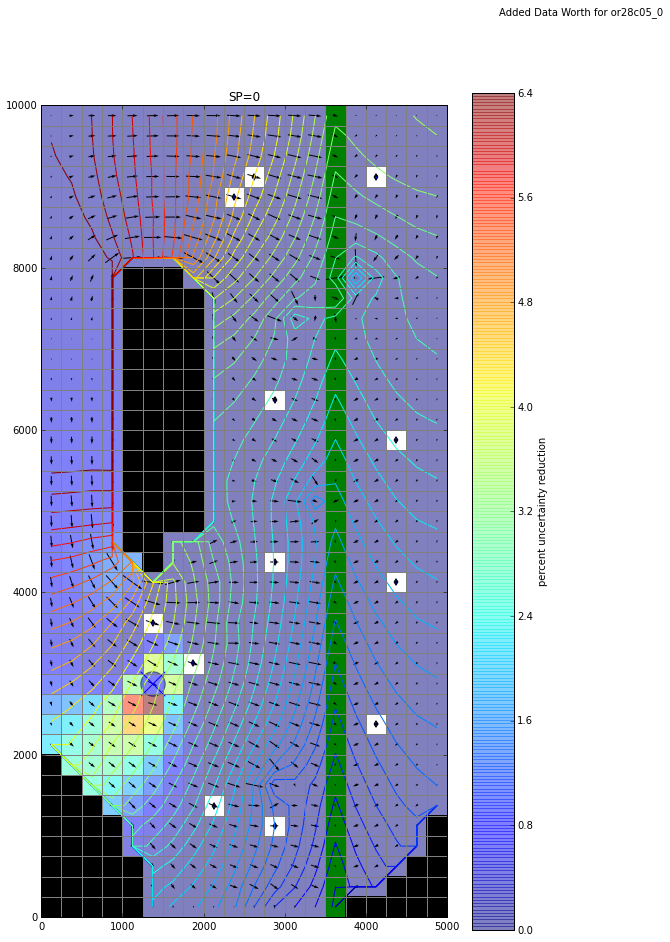

In [26]:
fig0 = plot_added_importance(df_new_worth_plot, ml, 'or28c05_0')

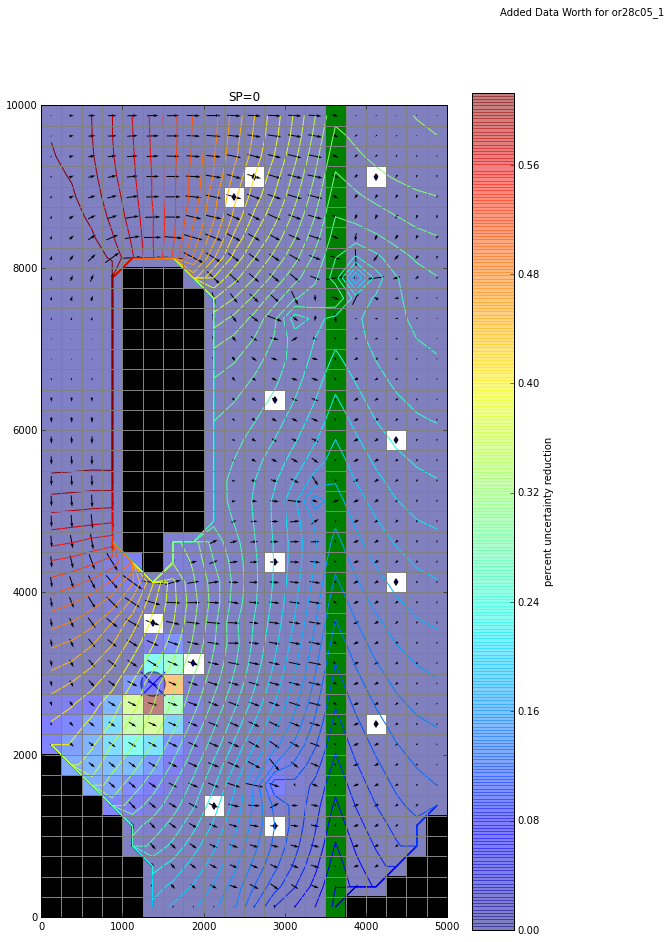

In [27]:
fig1 = plot_added_importance(df_new_worth_plot, ml, 'or28c05_1')

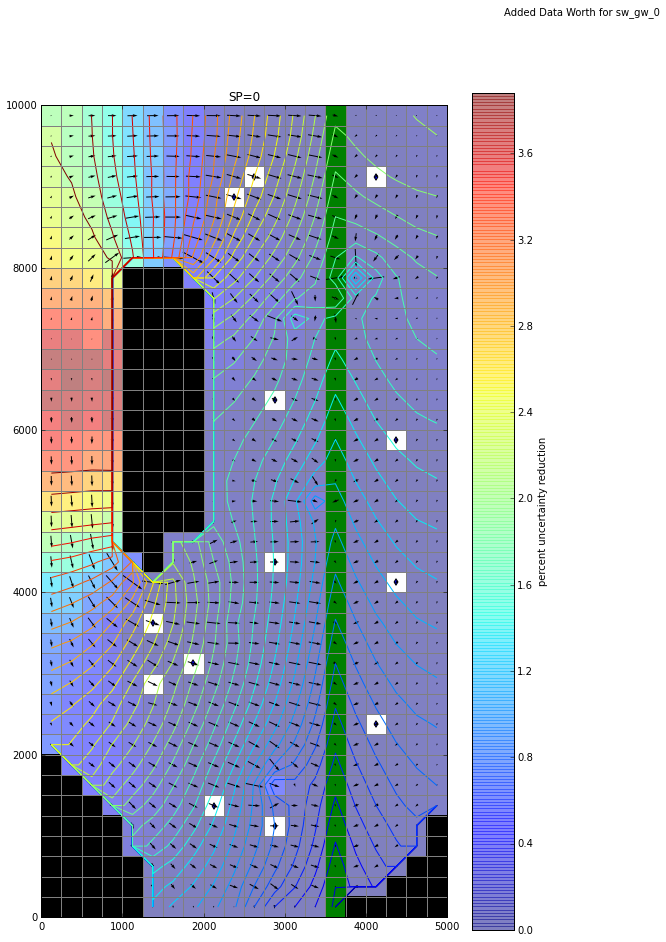

In [28]:
fig2 = plot_added_importance(df_new_worth_plot, ml, 'sw_gw_0')

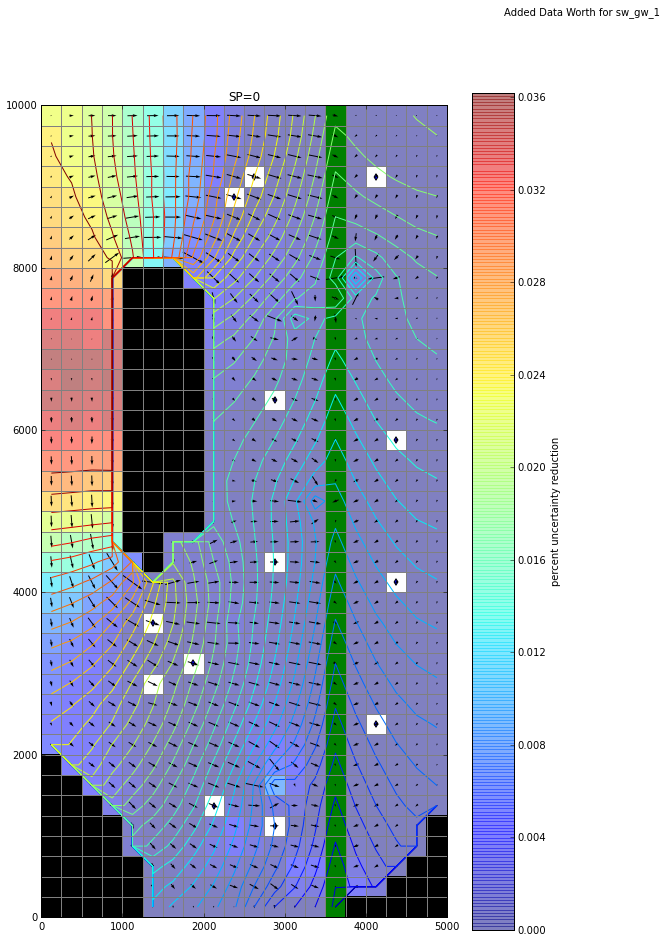

In [29]:
fig3 = plot_added_importance(df_new_worth_plot, ml, 'sw_gw_1')

### Next most valuable point
Evaluating these data worth maps, an obvious question is raised--what is the next most valuable data point? The issue is, there is a high density of importance around the most valuable observation point but if that most valuable observation was part of the calibration dataset, we would expect the next most valuable point to be somewhere else. In order to evaluate that, we ned to recompute data worth assuming that the recently identified point was part of the calibration set. This requires iterative calculations made possible by FOSM using the method `next_most_important_added_obs`

In [30]:
next_df = la.next_most_important_added_obs(forecast='sw_gw_0',niter=10, 
                                           obslist_dict=dict(zip(new_obs_list,new_obs_list)),
                                           base_obslist=la.pst.nnz_obs_names,reset_zero_weight=True)

../pyemu/sc.py:543: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting
  fore_diff_df.sort(inplace=True)


In [31]:
next_df

,best_obs,sw_gw_0_variance,unc_reduce_iter_base,unc_reduce_initial_base
or13c01_0,or13c01_0,48480.879873,3.881237,3.881237
or12c00_0,or12c00_0,47523.100671,1.975581,5.780141
or12c01_0,or12c01_0,46954.090359,1.197334,6.908268
or12c02_0,or12c02_0,46575.492202,0.806316,7.658881
or13c03_0,or13c03_0,46309.212365,0.571717,8.186810
or09c08_0,or09c08_0,46060.856435,0.536299,8.679204
or33c11_0,or33c11_0,45817.277451,0.528820,9.162126
or01c00_0,or01c00_0,45614.184874,0.443266,9.564780
or31c00_0,or31c00_0,45424.138661,0.416638,9.941568
or11c03_0,or11c03_0,45269.276715,0.340924,10.248599


This dataframe contains several columns and a separate row for each iteration. The columns are the name of the next most important observation for each iteration (`best_obs`), the variance of the forecast (in this case `sw_gw_0`) recalculated assuming the next_most important observation is in the calibration dataset, and then two columns reporting the percent uncertainty reduction. `unc_reduce_initial_base` indicates the percent uncertainty reduction relative to forecasts without any of the new observations, and `unc_reduce_iter_base`  indicates percent uncertainty reduction on an iteration by iteration basis.

Finally, we can plot the locations of the three most valuable potential observation locations, in order, on the map of data worth. Of course, the first most valuable point is collocated with the highest value in the color flood of potential data worth. The second most valuable point is nearby, but the third is closer to the forecast location. 

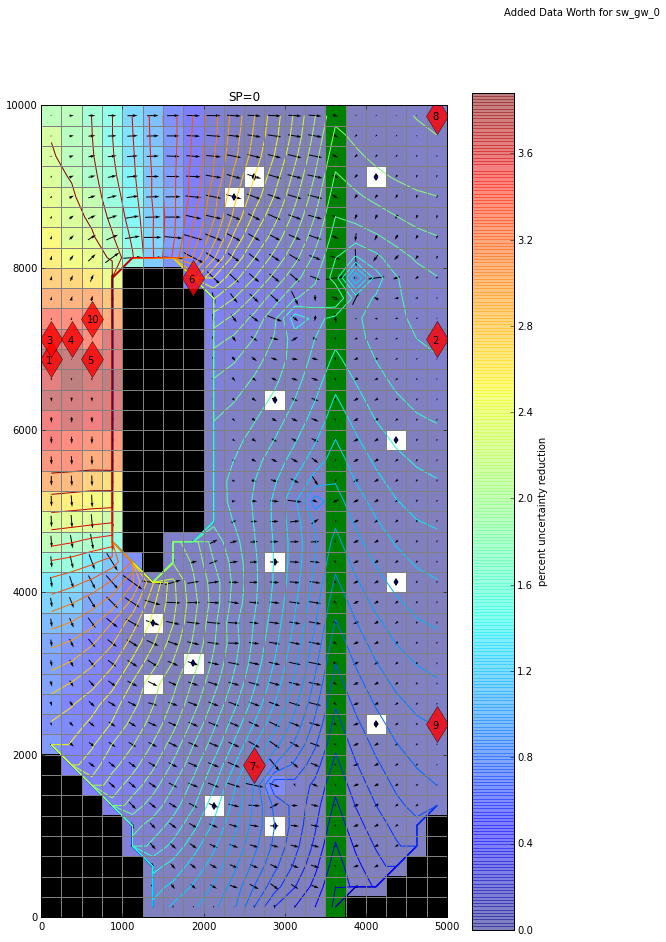

In [32]:
fig1 = plot_added_importance(df_new_worth_plot, ml, 'sw_gw_0', newlox=next_df.best_obs.tolist())
fig1.savefig('next_worth.pdf')

###Evaluting the subjective choices in the Prior

Earlier, we assumed that future recharge and future water use were just as uncertain as current recharge and water-use.  But what if we _believe_ that future recharge is infact more uncertain. How might that effect the results of the FOSM analyses.  Let's look...

In [33]:
# let's make the range of the future recharge parameter larger, implying that it is more uncertain
print(la.pst.parameter_data.loc["rch_2",["parlbnd","parubnd"]])
la.pst.parameter_data.loc["rch_2","parlbnd"] = 0.5
la.pst.parameter_data.loc["rch_2","parubnd"] = 1.5
print(la.pst.parameter_data.loc["rch_2",["parlbnd","parubnd"]])
# now get a new Schur instance with the updated pst
la1 = pyemu.Schur(jco=la.jco,pst=la.pst,forecasts=la.forecasts)


parlbnd    0.9
parubnd    1.1
Name: rch_2, dtype: object
parlbnd    0.5
parubnd    1.5
Name: rch_2, dtype: object


In [34]:
la.get_forecast_summary()

,percent_reduction,post_var,prior_var
sw_gw_1,0.516452,110972.261543,111548.355615
sw_gw_0,36.662109,50438.518215,79634.034592
or28c05_1,13.806425,0.666633,0.773414
or28c05_0,73.547647,0.106080,0.401023


In [35]:
la1.get_forecast_summary()

,percent_reduction,post_var,prior_var
sw_gw_1,0.108383,530959.767346,531535.861418
sw_gw_0,36.662109,50438.518215,79634.034592
or28c05_1,7.617459,1.295010,1.401790
or28c05_0,73.547647,0.106080,0.401023


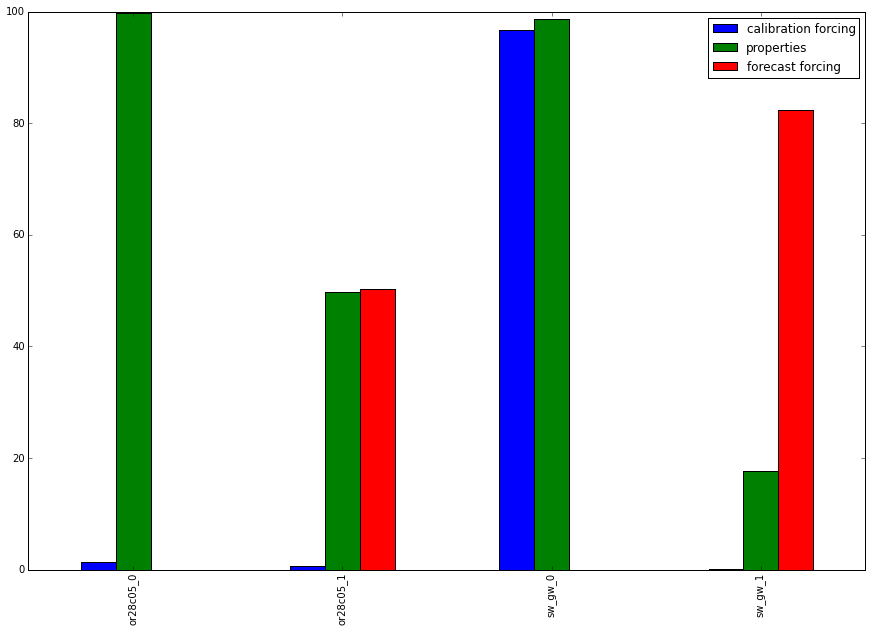

In [36]:
df = la1.get_par_contribution(pdict)
#select out the posterior column
df_reduce = df.xs("post",axis=1,level=1)
#calc the percent reduction in posterior
df_percent = 100.0 * (df_reduce.loc["base",:]-df_reduce)/df_reduce.loc["base",:]
#drop the base column
df_percent = df_percent.iloc[1:,:]
df_percent.T.plot(kind="bar", ylim=[0, 100], figsize=(15,10))

Notice how the forecast forcings now are the dominant source of uncertainty for both ``or28c05_1`` and ``sw_gw_1``.  This demonstrates the importance of recognizing and including future condition uncertainty in any forecast uncertainty analysis